In [81]:
import logging
import os
import warnings
import pypsa
import yaml
import pandas as pd
import geopandas as gpd
import numpy as np
import scipy as sp
import networkx as nx
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
import cartopy.feature as cfeature

from scipy.sparse import csgraph
from itertools import product
import re

from shapely.geometry import Point, LineString
import shapely, shapely.prepared
from shapely.wkt import loads
from shapely.validation import make_valid

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.patches as mpatches
warnings.filterwarnings('ignore')
logging.getLogger().setLevel(logging.WARNING)

In [82]:
red1 = '#891D2D'
red2 = '#BA3B31'
orange = '#F58221'
yellow = '#FCAF19'
brown = '#440A15'
purple1 = '#3B1053'
purple2 = '#76518E'
purple3 = '#B69DC7'
teal1 = '#032838'
teal2 = '#154655'
teal3 = '#527D77'
teal4 = '#8DB5AF'
green1 = '#294839'
green2 = '#6E966E'
green3 = '#A3BDA3'
beige1 = '#927F48'
beige2 = '#A89677'
beige3 = '#D2CDAD'

from matplotlib.colors import ListedColormap

In [83]:
def get_installed_capacity(network):

    capacities = network.generators.groupby(by='carrier')['p_nom'].sum()

    if 'ror' in capacities:
        capacities['hydro'] = capacities.get('hydro', 0) + capacities.pop('ror')

    if 'hydro' in network.storage_units.carrier.unique():
        hydro_capacity = network.storage_units[network.storage_units.carrier == 'hydro']['p_nom'].sum()
        capacities['hydro'] += hydro_capacity

    capacities.pop('load')
    capacities_df = capacities.to_frame().transpose()

    return capacities_df

def get_new_installed(network):
    
    capacity = pd.DataFrame(network.generators)
    hydro = pd.DataFrame(network.storage_units)[["p_nom_opt", "carrier", "p_nom"]]
    caps = pd.concat([capacity[["p_nom_opt", "carrier", "p_nom"]], hydro], ignore_index=True)
    caps["zubau"] = caps["p_nom_opt"] - caps["p_nom"]
    caps["year"] = np.ones(len(caps["p_nom_opt"]), dtype=int) * 2021

    data_agg = caps[["year", "carrier", "zubau"]]

    grouped_cap_change_B = data_agg.groupby(['year', 'carrier']).sum().unstack() / 1000
    grouped_cap_change_B.columns = grouped_cap_change_B.columns.droplevel(0)
    grouped_cap_change_B = grouped_cap_change_B.clip(lower=0)
    return grouped_cap_change_B

def get_power_prod(network):
    carrier_list = network.generators.carrier.unique()
    production_data = {}
    first_date = "2013-01-01"
    second_date = "2013-12-31"
    for carrier in carrier_list:
        production_data[carrier] = get_snapshot_generation(first_date, second_date, carrier, network).sum()

    df = pd.DataFrame([production_data])
    return df

def total_production(network):
    prod = pd.DataFrame(get_power_prod(network))
    prod.drop('load', axis=1, inplace=True)
    return prod.sum().sum()

def get_power_mix(network):
    total_prod = total_production(network)
    prod = get_power_prod(network)
    prod_series = prod.iloc[0].drop('load', errors='ignore')
    fractions = prod_series / total_prod

    df = pd.DataFrame(fractions).transpose()
    return df

def get_snapshot_demand(network, first_date, second_date):
    demand = network.loads_t.p_set.loc[first_date:second_date].sum(axis=1)*-1
    return demand

def get_snapshot_generation(first_date, second_date, carrier, network):
    if carrier == 'hydro':
        generation = network.storage_units_t.p_dispatch[first_date:second_date].sum(axis=1)
    else:
        generation = network.generators_t.p.loc[first_date:second_date].groupby(network.generators.carrier, axis=1).sum()[carrier]
    return generation

def custom_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 0 else ''

In [84]:
single_path = 'C:/Users/noraky/Documents/Test_4/pypsa-earth/27/elec_s_all_ec_lcopt_Co2L-1H.nc'
single_net = pypsa.Network(single_path)
single_generators = single_net.generators
single_generators_t = single_net.generators_t
single_bus = single_net.buses

carrier     CCGT    OCGT  biomass    oil  onwind  solar  hydro
p_nom    1363.99  948.92    65.58  11.74  127.34  164.9  732.2


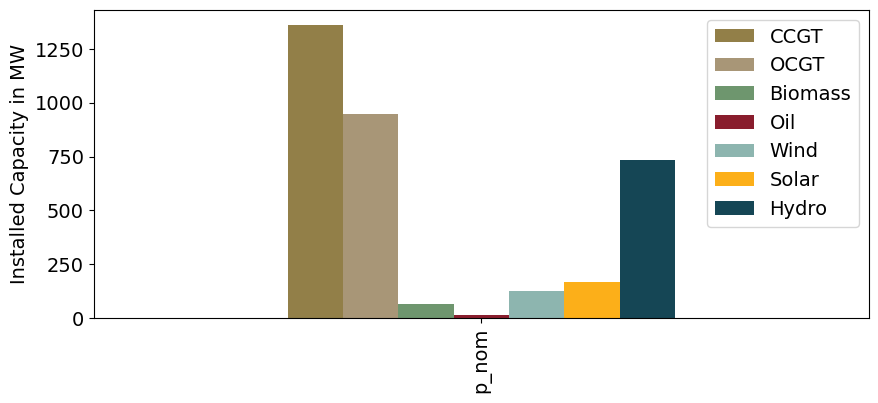

In [85]:
installed_capacity_21 = get_installed_capacity(single_net)

print(installed_capacity_21)
colors_cap = [beige1, beige2, green2, red1, teal4, yellow, teal2]
names = ['CCGT',    'OCGT',  'Biomass',   'Oil',  'Wind',  'Solar'  ,'Hydro']
installed_capacity_21.columns = names
installed_capacity_21.plot(kind='bar',color=colors_cap,figsize=(10, 4), legend=True)

plt.ylabel('Installed Capacity in MW')
plt.show()

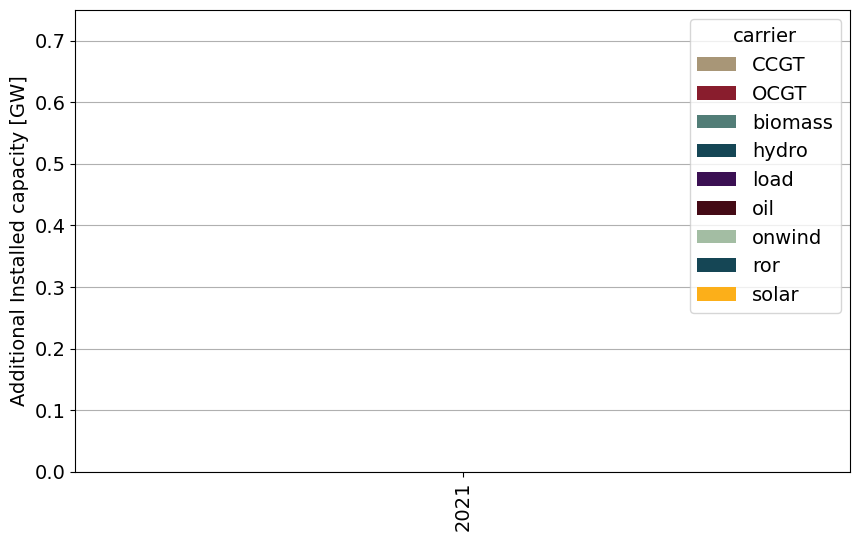

In [86]:
colors = [beige2,red1,teal3,teal2,purple1,brown, green3, teal2, yellow]
grouped_cap_change_B = get_new_installed(single_net)
grouped_cap_change_B.plot.bar(stacked=True, figsize=(10, 6), color=colors)

plt.ylabel('Additional Installed capacity [GW]')
plt.xlabel('')
plt.xticks(range(len(grouped_cap_change_B.index)), grouped_cap_change_B.index, rotation=90)
plt.ylim(0.0,0.75)
plt.grid(axis = 'y',zorder = 0)

     onwind     solar       ror      CCGT       biomass          OCGT  \
0  0.023464  0.038766  0.405283  0.532488  1.053294e-11  2.668430e-11   

            oil  
0  6.271811e-14  


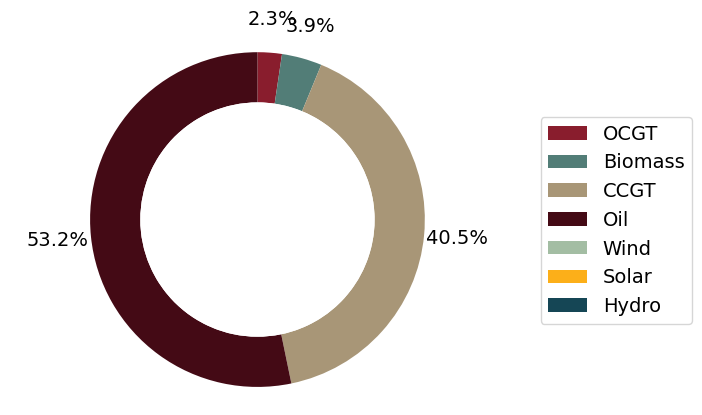

In [87]:
colors_27 =[green3,yellow,teal2,beige2,teal3,red1,brown]
colors_all = [red1,teal3,beige2,brown,green3,yellow,teal2]

power_mix_df = get_power_mix(single_net)
print(power_mix_df)
plt.rcParams['font.size'] = 14
fig, ax = plt.subplots()
wedges, texts, autotexts = ax.pie(power_mix_df.iloc[0].values, autopct=custom_autopct, startangle=90, counterclock=False, wedgeprops=dict(width=0.3), pctdistance=1.2, colors=colors_all)

for autotext in autotexts:
    if autotext.get_text() == '0.0%':
        autotext.set_visible(False)

ax.axis('equal')
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig.gca().add_artist(centre_circle)
carriers_all = ['OCGT', 'Biomass', 'CCGT', 'Oil', 'Wind', 'Solar', 'Hydro']
carriers_27 = ['Wind', 'Solar', 'Hydro', 'CCGT', 'Biomass', 'OCGT', 'Oil']
plt.legend(carriers_all,loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.show()

(<matplotlib.collections.PatchCollection at 0x2bfb7ece590>,
 <matplotlib.collections.LineCollection at 0x2bfb6a190c0>)

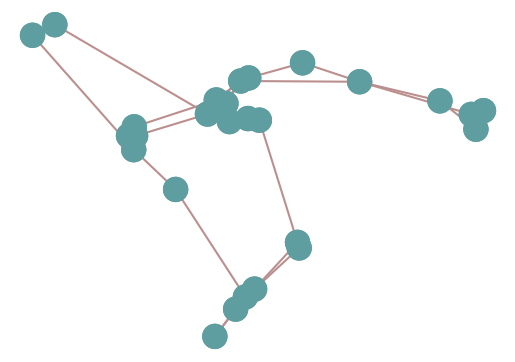

In [88]:
single_net.plot()

In [89]:
single_net.objective

29032732.385433704

In [96]:
single_net.objective_constant

259946426.23177826

In [90]:
(single_net.statistics.capex() + single_net.statistics.opex(aggregate_time="sum")).div(1e6).sum()


353.08905247828943

In [95]:
lines_pos = single_net.lines[['s_nom_opt', 's_nom', 's_nom_min', 's_nom_max', 's_max_pu']] #Add lines in base network, adding components s_nom_min

In [92]:
single_net.statistics()

Capacity Factor  Capital Expenditure  \
            carrier                                                    
Generator   Biomass                1.436694e-10         1.823225e+07   
            Combined-Cycle Gas     3.492084e-01         1.152150e+08   
            Oil                    4.778711e-12         4.488738e+05   
            Onshore Wind           1.648226e-01         1.391770e+07   
            Open-Cycle Gas         2.515430e-11         4.482182e+07   
            Run of River           1.000000e+00         9.822414e+07   
            Solar                  2.102867e-01         8.386148e+06   
            load                   6.602477e-18         0.000000e+00   
Line        AC                     9.677357e-02         3.411424e+07   
Link        battery charger        4.193514e-01         5.038680e-03   
            battery discharger     3.396746e-01         0.000000e+00   
Load        -                               NaN                  NaN   
StorageUnit Reservoir & Dam        5.000000e-01         0.000000e+00   
Store       Battery Storage        5.001082e-01         3.114005e-03   

                                Curtailment      Dispatch  Installed Capacity  \
            carrier                                                             
Generator   Biomass                0.000000  8.253530e-05        6.558000e+01   
            Combined-Cycle Gas     0.000000  4.172535e+06        1.363990e+03   
            Oil                    0.000000  4.914541e-07        1.174000e+01   
            Onshore Wind           0.107176  1.838594e+05        1.273400e+02   
            Open-Cycle Gas         0.000000  2.090961e-04        9.489200e+02   
            Run of River           0.000000  3.175763e+06        3.625300e+02   
            Solar                  0.086632  3.037642e+05        1.649000e+02   
            load                   0.000000  1.561618e-06        2.700000e+10   
Line        AC                          NaN -4.405506e+06        2.113691e+04   
Link        battery charger             NaN -4.806746e-04        0.000000e+00   
            battery discharger          NaN -4.326071e-04        0.000000e+00   
Load        -                           NaN -9.455076e+06                 NaN   
StorageUnit Reservoir & Dam        0.000000  1.619155e+06        3.696700e+02   
Store       Battery Storage             NaN  0.000000e+00        0.000000e+00   

                                Market Value  Operational Expenditure  \
            carrier                                                     
Generator   Biomass             1.288960e+01             1.235349e-03   
            Combined-Cycle Gas  1.288984e+01             5.378330e+07   
            Oil                 1.289018e+01             6.400530e-05   
            Onshore Wind        1.288930e+01             4.565201e+03   
            Open-Cycle Gas      1.289002e+01             3.009933e-03   
            Run of River        1.289018e+01             3.218799e+04   
            Solar               1.289019e+01             6.054626e+03   
            load                1.289007e+04             1.577273e-03   
Line        AC                  2.327487e-05                      NaN   
Link        battery charger     8.661078e-01             0.000000e+00   
            battery discharger  1.758836e+00             0.000000e+00   
Load        -                  -1.289000e+01                      NaN   
StorageUnit Reservoir & Dam     1.289018e+01             1.697703e+04   
Store       Battery Storage             -inf            -3.257831e-24   

                                Optimal Capacity       Revenue        Supply  \
            carrier                                                            
Generator   Biomass                 6.558000e+01  1.063847e-03  8.253530e-05   
            Combined-Cycle Gas      1.363990e+03  5.378331e+07  4.172535e+06   
            Oil                     1.174000e+01  6.334934e-06  4.914541e-07   
            O

In [93]:
round(single_net.loads_t.p_set.sum().sum()/1000000,8)

9.45507556

CCGT:  4172534.5826706057
OCGT:  0.00020909609881166472
Wind:  183859.3596504621
Solar:  303764.2192163698
Hydro:  4794917.399956207
Oil:  4.914541199080545e-07
Biomass:  8.253530150717525e-05
Total:  9455075.561785767


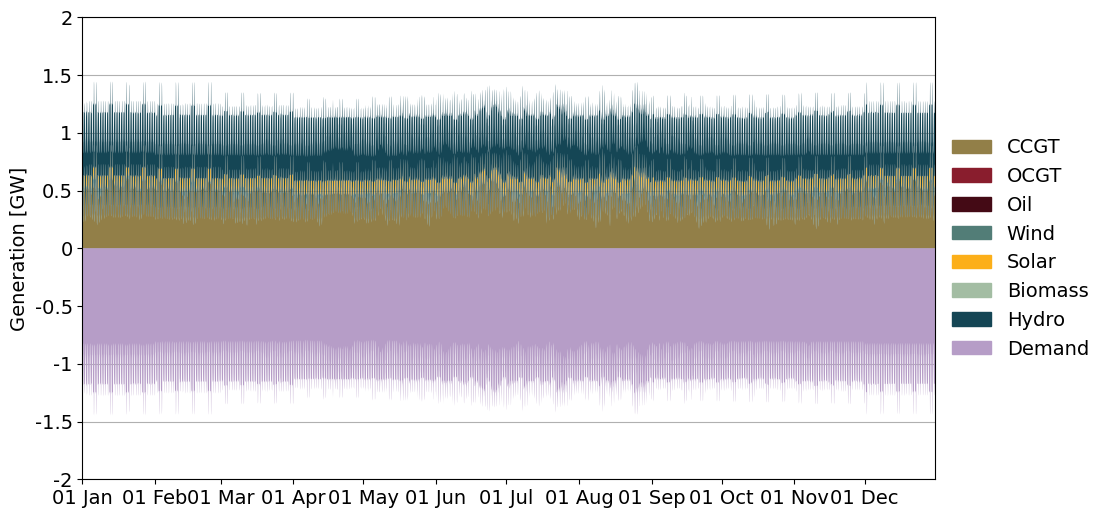

In [94]:
first_date = "2013-01-01"
second_date = "2013-12-31"
year = '2021'

CCGT = get_snapshot_generation(first_date, second_date, 'CCGT', single_net)
OCGT = get_snapshot_generation(first_date, second_date, 'OCGT',   single_net)
Oil = get_snapshot_generation(first_date, second_date, 'oil', single_net)
Wind = get_snapshot_generation(first_date, second_date, 'onwind', single_net)
Solar = get_snapshot_generation(first_date, second_date, 'solar', single_net)
Biomass = get_snapshot_generation( first_date, second_date, 'biomass', single_net)
Hydro = get_snapshot_generation(first_date, second_date, 'ror', single_net)
Hydro += get_snapshot_generation(first_date, second_date, 'hydro', single_net)
demand = get_snapshot_demand(single_net, first_date, second_date)   

print('CCGT: ', CCGT.sum())
print('OCGT: ', OCGT.sum())
print('Wind: ', Wind.sum())
print('Solar: ', Solar.sum())
print('Hydro: ', Hydro.sum())
print('Oil: ', Oil.sum())
print('Biomass: ', Biomass.sum())
print('Total: ', CCGT.sum() + OCGT.sum() + Wind.sum() + Solar.sum() + Hydro.sum() + Oil.sum() + Biomass.sum())

fig, ax=plt.subplots(figsize = (11,6))
A = plt.stackplot(CCGT.index,CCGT,OCGT,Oil, Wind, Solar, Biomass, Hydro, #,pbattery
                  colors=[beige1,green1,red1,teal3,yellow,green3,teal2], zorder = 2) #,   purple3
plt.stackplot(CCGT.index,demand, colors=[purple3], zorder = 2) #,nbattery
plt.xticks(rotation = 0)
plt.yticks()
scale_y = 1e3
ticks_y = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x/scale_y))
ax.yaxis.set_major_formatter(ticks_y)
myFmt = mdates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(myFmt)
ax.set_ylabel('Generation [GW]')

start_date = pd.to_datetime(first_date)
end_date = pd.to_datetime(second_date)

ax.set_xlim(start_date, end_date)
ax.set_ylim(-2000, 2000)

CCGT_patch = mpatches.Patch(color=beige1, label ='CCGT')
OCGT_patch = mpatches.Patch(color=red1, label ='OCGT')
oil_patch = mpatches.Patch(color = brown, label = 'Oil')
wind_patch = mpatches.Patch(color=teal3, label ='Wind')
solar_patch = mpatches.Patch(color=yellow, label ='Solar')
biomass_patch = mpatches.Patch(color = green3, label = 'Biomass')
hydro_patch = mpatches.Patch(color = teal2, label = 'Hydro')
load_patch = mpatches.Patch(color=purple3, label ='Demand')
handles=[CCGT_patch,OCGT_patch,oil_patch, wind_patch, solar_patch, biomass_patch, hydro_patch, load_patch]
ax.legend(handles=handles, frameon = False, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(axis='y', zorder=0)